---------------------------------------------------------------------------------------------------------------

------------------------------ WELCOME ON THE CONVERSION RATE PROJECT ! ----------------------------------------

In [1]:
# Using Pandas, Numpy as packages to open the csv file

import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('CSVconversion_data_train.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


-------------------------------- PART I : EXPLORATORY DATA ANALYSIS --------------------------------------------

In [3]:
df.describe()

,age,new_user,total_pages_visited,converted
count,284580.000000,284580.000000,284580.000000,284580.000000
mean,30.564203,0.685452,4.873252,0.032258
std,8.266789,0.464336,3.341995,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


Looking for Nan:

In [5]:
df.isna().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

Good news ! No Nan detected here.
=> Will simplify our pipeline to come : no SimpleImputer needed.

In [6]:
duplicates = df.duplicated().sum()
print(f"Number of duplicates: {duplicates}")

Number of duplicates: 268769


Lot of duplicates: drop them to clarify the dataframe. We keep the first line of each.

In [7]:
df = df.drop_duplicates(keep='first')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15811 entries, 0 to 284563
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   country              15811 non-null  object
 1   age                  15811 non-null  int64 
 2   new_user             15811 non-null  int64 
 3   source               15811 non-null  object
 4   total_pages_visited  15811 non-null  int64 
 5   converted            15811 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 864.7+ KB


In [8]:
#!pip install matplotlib
#!pip install seaborn

In [9]:
# Import now dataviz libraries
import matplotlib.pyplot as plt
import seaborn as sns


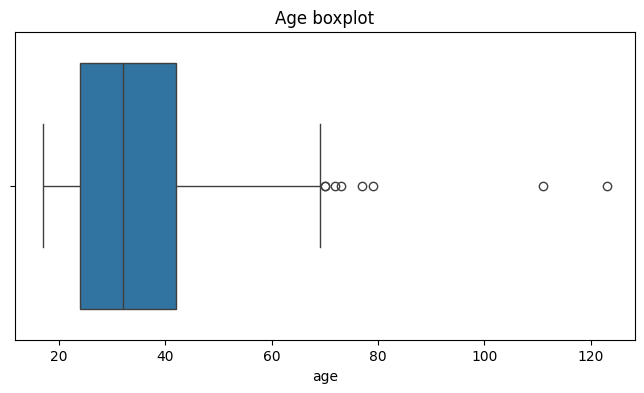

In [10]:
# See now the 'age' feature' in a boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['age'])

plt.title('Age boxplot')
plt.xlabel('age')
plt.show()

Obviously there are 2 outliers, we have to delete them.

In [11]:
big_ages_to_remove = df['age'].nlargest(2).index
df= df.drop(big_ages_to_remove)

# Check after drop:
print(df['age'].nlargest(2))


230590    79
268311    77
Name: age, dtype: int64


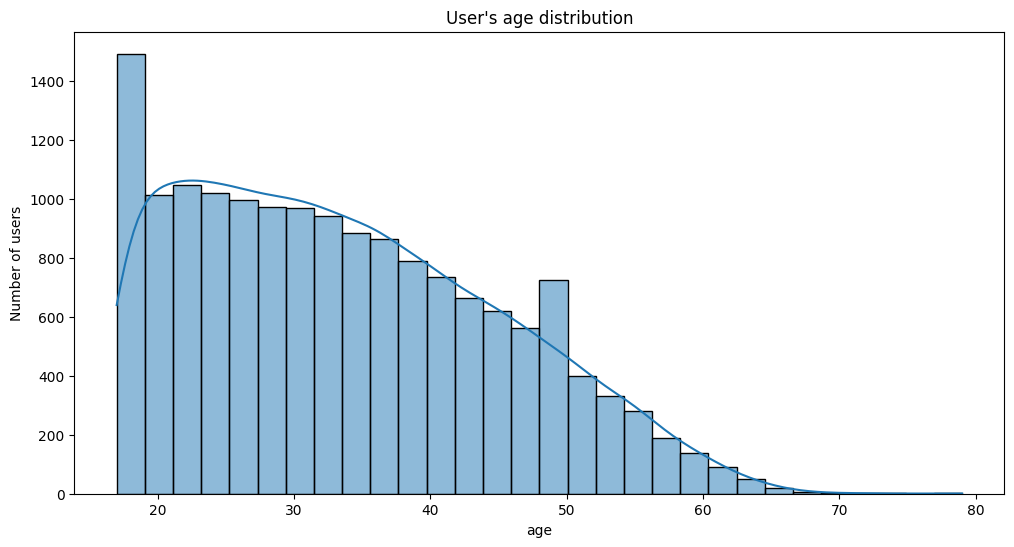

In [12]:
# what about age distribution ?
plt.figure(figsize=(12, 6))
sns.histplot(df['age'], bins=30, kde=True)
plt.title("User's age distribution")
plt.xlabel('age')
plt.ylabel('Number of users')
plt.show()

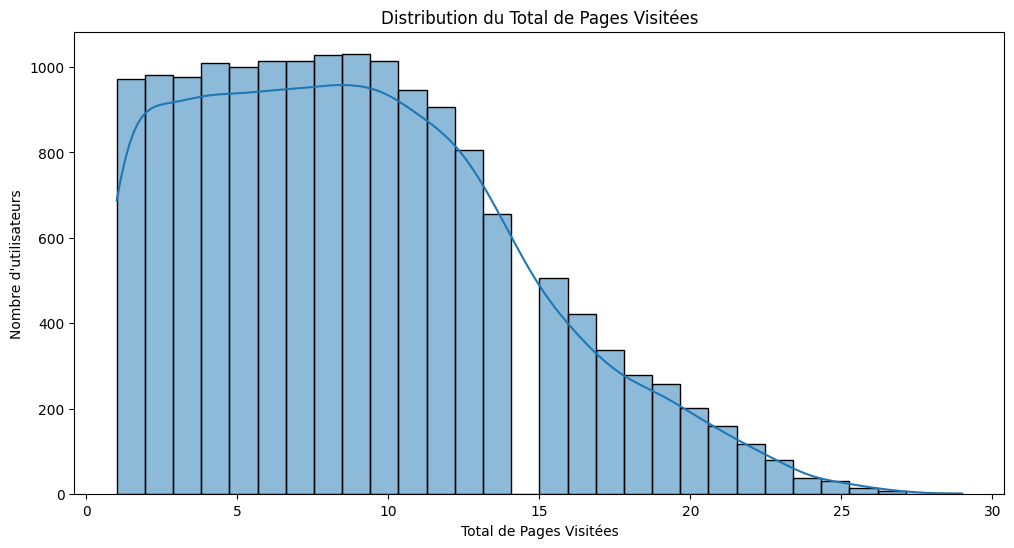

In [13]:
# and about distribution of visited pages ?
plt.figure(figsize=(12, 6))
sns.histplot(df['total_pages_visited'], bins=30, kde=True)
plt.title('Distribution du Total de Pages Visitées')
plt.xlabel('Total de Pages Visitées')
plt.ylabel('Nombre d\'utilisateurs')
plt.show()

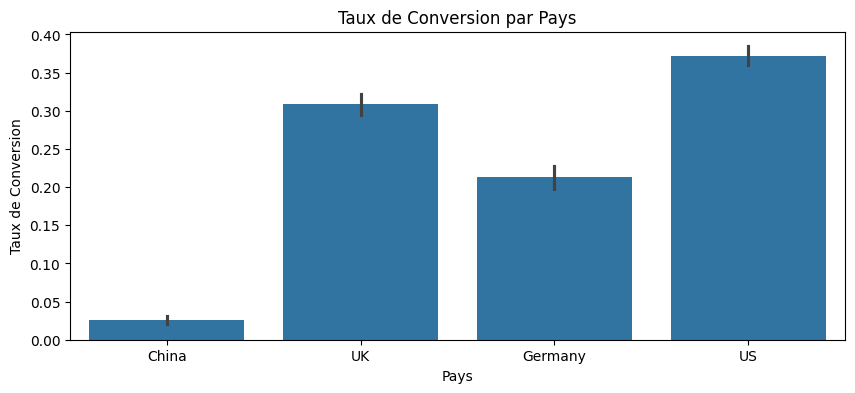

In [14]:
# Conversion rate by country
plt.figure(figsize=(10, 4))
sns.barplot(x='country', y='converted', data=df)
plt.title('Taux de Conversion par Pays')
plt.xlabel('Pays')
plt.ylabel('Taux de Conversion')
plt.show()

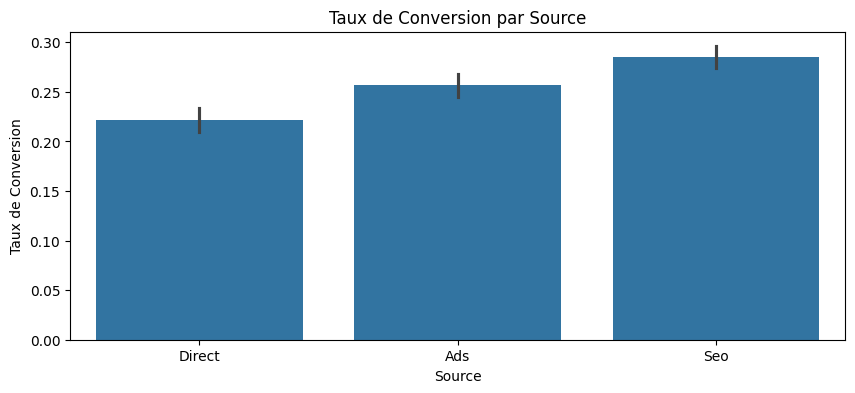

In [15]:
# Is the conversion rate influenced by source ?
plt.figure(figsize=(10, 4))
sns.barplot(x='source', y='converted', data=df)
plt.title('Taux de Conversion par Source')
plt.xlabel('Source')
plt.ylabel('Taux de Conversion')
plt.show()

No big difference, but little more users who convertes arrived on the site via a search engine (SEO)  
and clicking on a advertisement (ads)

Let's check if some features are correlated.
First we need to encode categorical features ('country' and 'source')

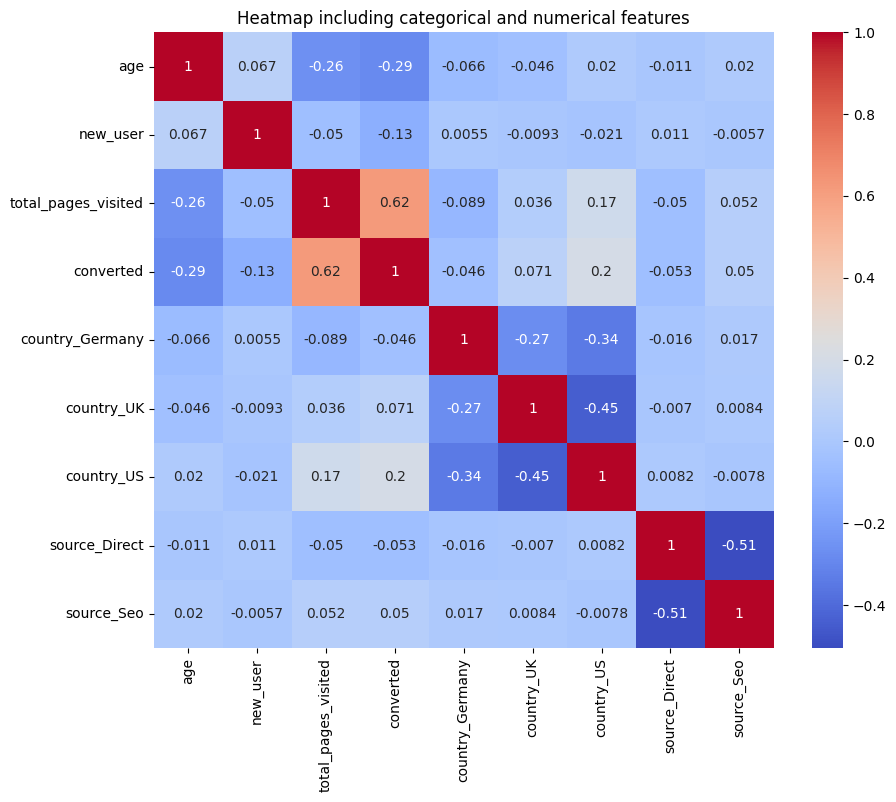

In [16]:
df= pd.get_dummies(df, drop_first=True)

# Matrix correlation
corr= df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True)
plt.title('Heatmap including categorical and numerical features')
plt.show()

Seems like the number of total visited pages correlates with our target;  
And negatively 'age' a little bit too (-0.29).  
Could mean the younger the user, the better luck to get a conversion.
Country_US is at 0.2 which is not null

In [17]:
# Check now if the datas in the label column 'converted' are balanced :
conversion_counts = df['converted'].value_counts(normalize=True)

# Proportion of each
print(conversion_counts)

converted
0    0.743121
1    0.256879
Name: proportion, dtype: float64


This is clearly unbalanced ! We'll have to equilibrate that in a few moment.

---------------------- Let's prepare now the datas for Supervised Machine Learning ---------------------------

---------------------------------- PART II : SUPERVISED MACHINE LEARNING ----------------------------------------

1. Let begin with a LOGISTIC REGRESSION as it is a classification problem: the answer is a binary choice  
=> is there a conversion, yes or no ?

In [18]:
#!pip install scikit-learn

In [19]:
#!pip install imbalanced-learn


In [20]:
print(df.columns)


Index(['age', 'new_user', 'total_pages_visited', 'converted',
       'country_Germany', 'country_UK', 'country_US', 'source_Direct',
       'source_Seo'],
      dtype='object')


In [29]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

categorical_features = ['country_Germany', 'country_UK', 'country_US', 'source_Direct', 'source_Seo']
numeric_features = df.drop(['converted'] + categorical_features, axis=1).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  
        ('cat', 'passthrough', categorical_features) 
    ])

X = df.drop('converted', axis=1)
y = df['converted']

X_preprocessed = preprocessor.fit_transform(X)

# train test split, keeping 20% of dataset to test the model
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Now apply SMOTE to 'converted' column
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)


In [34]:
# Import 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

# Scaling datas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

# Our model to fit
lrg = LogisticRegression(max_iter=1000)
lrg.fit(X_train_sm, y_train_sm)

# Predictions
y_pred_lrg = lrg.predict(X_test_scaled)

# and now metrics
accuracy_lrg = accuracy_score(y_test, y_pred_lrg)
precision_lrg = precision_score(y_test, y_pred_lrg)
recall_lrg = recall_score(y_test, y_pred_lrg)
f1_lrg = f1_score(y_test, y_pred_lrg)

print('---------------------')
print("Régression Logistique sans régularisation:")
print(f"Accuracy: {accuracy_lrg}")
print(f"Precision: {precision_lrg}")
print(f"Recall: {recall_lrg}")
print(f"F1 Score: {f1_lrg}")


---------------------
Régression Logistique sans régularisation:
Accuracy: 0.812460468058191
Precision: 0.9438596491228071
Recall: 0.31796690307328607
F1 Score: 0.47568523430592397


F1 score is 73.73% : quite good but higher would sound better.
Remember that F1score is the harmonic mean between Precision and Recall.

We can improve this, for example using Regularization with Ridge and Lasso.  
Reminder: Regularization prevents overfitting so it's interesting to do it on train set,  
before we test our model on the next dataset of the exercise 'dataset test'

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Logistic Regression with Lasso (= L1 regularization)
lrg_lasso = LogisticRegression(penalty='l1', C=1.0, solver='saga', max_iter=1000)
lrg_lasso.fit(X_train_scaled, y_train_sm)

y_pred_lasso = lrg_lasso.predict(X_test_scaled)

# Logistic Regression with Ridge (= L2 regularization)
lrg_ridge = LogisticRegression(penalty='l2', C=1.0, max_iter=1000) # Adjust C as needed
lrg_ridge.fit(X_train_scaled, y_train_sm)

y_pred_ridge = lrg_ridge.predict(X_test_scaled)

# Metrics for Lasso
accuracy_lasso = accuracy_score(y_test, y_pred_lasso)
precision_lasso = precision_score(y_test, y_pred_lasso)
recall_lasso = recall_score(y_test, y_pred_lasso)
f1_lasso = f1_score(y_test, y_pred_lasso)

# Metrics for Ridge
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
precision_ridge = precision_score(y_test, y_pred_ridge)
recall_ridge = recall_score(y_test, y_pred_ridge)
f1_ridge = f1_score(y_test, y_pred_ridge)

print("Logistic Regression with Lasso Regularization:")
print(f"Accuracy: {accuracy_lasso}")
print(f"Precision: {precision_lasso}")
print(f"Recall: {recall_lasso}")
print(f"F1 Score: {f1_lasso}")
print ('---------------------')
print("Logistic Regression with Ridge Regularization:")
print(f"Accuracy: {accuracy_ridge}")
print(f"Precision: {precision_ridge}")
print(f"Recall: {recall_ridge}")
print(f"F1 Score: {f1_ridge}")


Logistic Regression with Lasso Regularization:
Accuracy: 0.8387096774193549
Precision: 0.6530054644808743
Recall: 0.8475177304964538
F1 Score: 0.7376543209876543
---------------------
Logistic Regression with Ridge Regularization:
Accuracy: 0.8387096774193549
Precision: 0.6530054644808743
Recall: 0.8475177304964538
F1 Score: 0.7376543209876543


F1 score is slightly better with Lasso : 73.8%
We can try an XGBoost model to improve it, which is an ensembling model.

In [ ]:
#!pip install xgboost

In [33]:
import xgboost as xgb

# Create our XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,  
    max_depth=3,       
    learning_rate=0.1,
    reg_lambda=1.0,    
    reg_alpha=0.0,     
    use_label_encoder=False,
    eval_metric='logloss' 
)

# Training model with balanced datas
xgb_clf.fit(X_train_scaled, y_sm)

# Predictioons
y_pred_xgb = xgb_clf.predict(X_test_scaled)

# And metrics as usual
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print ('................')
print("XGBoost - Accuracy: {}".format(accuracy_xgb))
print("XGBoost - Precision: {}".format(precision_xgb))
print("XGBoost - Recall: {}".format(recall_xgb))
print("XGBoost - F1 Score: {}".format(f1_xgb))
print ('................')


NameError: name 'y_sm' is not defined

Disappointment !  
We could try to optimize hyperparameters of XGBoost model

......................... CAUTION : THIS MAY TAKE SOME RESSOURCE/TIME ON LAPTOP ...........................  
.........................                    (Took > 3mn)                       ...........................

Using GridSearch Cross Validation to improve XGBoost

In [ ]:
from sklearn.model_selection import GridSearchCV

# Our params to be tested
param_grid = {
    'n_estimators': [200, 300, 400], 
    'max_depth': [4, 5, 6],           
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'reg_lambda': [1.0, 1.5],          # L2
    'reg_alpha': [0.0, 0.5]            # L1
}

# Initiate here model XGBoost
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_clf, 
    param_grid=param_grid, 
    scoring='accuracy',      
    cv=5,                    
    verbose=1,               
    n_jobs=-1                # Use max CPU !
)

# Go !
grid_search.fit(X_train_scaled, y_sm)

print("Best params:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Use better model to make predictions
y_pred_best = grid_search.predict(X_test_scaled)

accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)

print("XGBoost with GridSearch - Accuracy: {}".format(accuracy_best))
print("XGBoost with GridSearch - Precision: {}".format(precision_best))
print("XGBoost with GridSearch - Recall: {}".format(recall_best))
print("XGBoost with GridSearch - F1 Score: {}".format(f1_best))


Fitting 5 folds for each of 180 candidates, totalling 900 fits


Best params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 1.5}
Best score: 0.8711316298564983
XGBoost with GridSearch - Accuracy: 0.8380771663504112
XGBoost with GridSearch - Precision: 0.6630859375
XGBoost with GridSearch - Recall: 0.8026004728132388
XGBoost with GridSearch - F1 Score: 0.7262032085561497


F1 score is now 72.62%

Well...   
Results are (a few) better than before, when using linear regression (71.86%) !  

My explanation would be: maybe we have here something linear between our feature/label to predict.  
As we saw the number of pages visited seemed to be highly correlated with the conversion rate.

We can try another model : Standard Vector Machine (SVM) using SVC in scikitlearn

In [ ]:
from sklearn.svm import SVC
 # for example test kernel: linear, poly, rbf, sigmoid
 
svm = SVC(kernel='linear') # test linear kernel
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

# Calculation and display of performance metrics
print ('................')
print("SVM - Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM - Precision:", precision_score(y_test, y_pred_svm))
print("SVM - Recall:", recall_score(y_test, y_pred_svm))
print("SVM - F1 Score:", f1_score(y_test, y_pred_svm))
print ('................')

................
SVM - Accuracy: 0.859898798228969
SVM - Precision: 0.7818181818181819
SVM - Recall: 0.6607565011820331
SVM - F1 Score: 0.7162075592568866
................


Our best F1score is still with logistic regression regularized with Lasso : 71.86%

So this should be the model we'd take now to fit on the dataset "test" of the exercise

---------------------------- PART III : TRAINING MODEL ON DATASET 'TEST' -----------------------------------------

In [ ]:
df2 = pd.read_csv ('conversion_data_test.csv')
df2.head()

,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3


In [ ]:
df2.describe()

,age,new_user,total_pages_visited
count,31620.000000,31620.000000,31620.000000
mean,30.620746,0.685579,4.870398
std,8.316736,0.464292,3.333128
min,17.000000,0.000000,1.000000
25%,24.000000,0.000000,2.000000
50%,30.000000,1.000000,4.000000
75%,36.000000,1.000000,7.000000
max,69.000000,1.000000,26.000000


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31620 entries, 0 to 31619
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   country              31620 non-null  object
 1   age                  31620 non-null  int64 
 2   new_user             31620 non-null  int64 
 3   source               31620 non-null  object
 4   total_pages_visited  31620 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.2+ MB


In [ ]:
df2.isna().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
dtype: int64

In [ ]:
duplicates = df2.duplicated().sum()
print(f"Number of duplicates: {duplicates}")

Number of duplicates: 24140


In [ ]:
df2 = df2.drop_duplicates(keep='first')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7480 entries, 0 to 31618
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   country              7480 non-null   object
 1   age                  7480 non-null   int64 
 2   new_user             7480 non-null   int64 
 3   source               7480 non-null   object
 4   total_pages_visited  7480 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 350.6+ KB


-----------------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------------

2. Trying another model: XGBoost, which is an ensembling model.

In [ ]:
#!pip install xgboost
from xgboost import XGBClassifier

# Our model:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Training model
xgb.fit(X_train, y_train)

# Prediction on test set
y_pred_xgb = xgb.predict(X_test)

# Calculation and display of performance metrics
print("XGBoost - Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost - Precision:", precision_score(y_test, y_pred_xgb))
print("XGBoost - Recall:", recall_score(y_test, y_pred_xgb))
print("XGBoost - F1 Score:", f1_score(y_test, y_pred_xgb))


XGBoost - Accuracy: 0.8390259329538267
XGBoost - Precision: 0.7390070921985815
XGBoost - Recall: 0.6158392434988179
XGBoost - F1 Score: 0.6718246292714377


In [ ]:
from sklearn.svm import SVC

# Our model:
svm = SVC(kernel='linear')  # 'linear', 'poly', 'rbf', 'sigmoid'

# Training
svm.fit(X_train, y_train)

# Prediction on test set
y_pred_svm = svm.predict(X_test)

# Calculation and display of performance metrics
print("SVM - Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM - Precision:", precision_score(y_test, y_pred_svm))
print("SVM - Recall:", recall_score(y_test, y_pred_svm))
print("SVM - F1 Score:", f1_score(y_test, y_pred_svm))


SVM - Accuracy: 0.859898798228969
SVM - Precision: 0.7818181818181819
SVM - Recall: 0.6607565011820331
SVM - F1 Score: 0.7162075592568866


                        RESULT COMPARISON BETWEEN THOSE 3 MODELS

In [ ]:
results = {
    "Model": ["Régression Logistique", "XGBoost", "SVM"],
    "Accuracy": [0.8595825426944972, 0.8390259329538267, 0.859898798228969],
    "Precision": [0.7753424657534247, 0.7390070921985815, 0.7818181818181819],
    "Recall": [0.6690307328605201, 0.6158392434988179, 0.6607565011820331],
    "F1 Score": [0.7182741116751268, 0.6718246292714377, 0.7162075592568866]
}
df_results = pd.DataFrame(results)

df_results


,Model,Accuracy,Precision,Recall,F1 Score
0,Régression Logistique,0.859583,0.775342,0.669031,0.718274
1,XGBoost,0.839026,0.739007,0.615839,0.671825
2,SVM,0.859899,0.781818,0.660757,0.716208


                            WELL, WE'D BETTER USE A GRAPH:

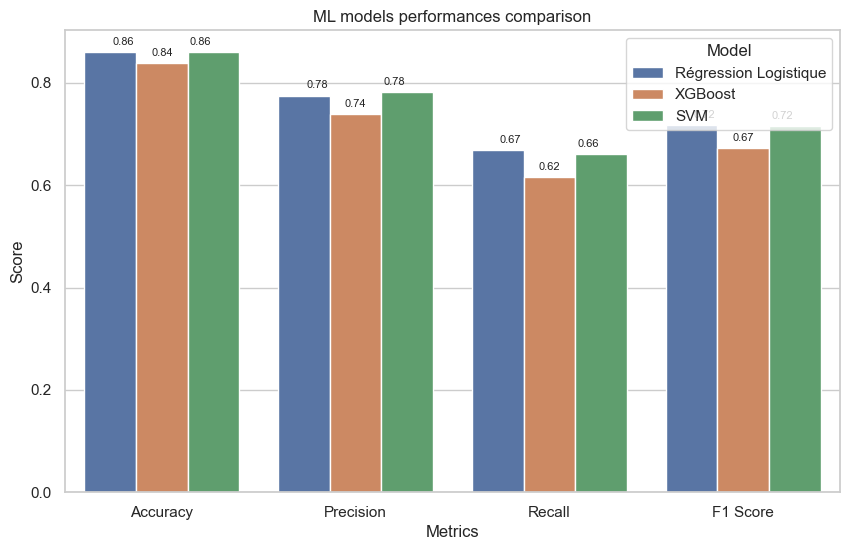

In [ ]:
results = {
    "Accuracy": [0.8595825426944972, 0.8390259329538267, 0.859898798228969],
    "Precision": [0.7753424657534247, 0.7390070921985815, 0.7818181818181819],
    "Recall": [0.6690307328605201, 0.6158392434988179, 0.6607565011820331],
    "F1 Score": [0.7182741116751268, 0.6718246292714377, 0.7162075592568866]
}

# Define the models
models = ["Régression Logistique", "XGBoost", "SVM"]

# Convert the results to a DataFrame
df_results = pd.DataFrame(results, index=models)

# Melt the DataFrame for visualization
df_melted = df_results.reset_index().melt(id_vars="index")
df_melted.columns = ['Model', 'Metric', 'Value']

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', hue='Model', data=df_melted)

# Add values on top of bars
for i in range(len(models)):
    for j in range(len(df_results.columns)):
        plt.text(j + i * 0.2 - 0.2, df_results.iloc[i, j] + 0.01, str(round(df_results.iloc[i, j], 2)), ha='center', va='bottom', fontsize=8)

plt.title('ML models performances comparison')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.legend(title='Model')

plt.show()